# Models

Group project for the 2019 Data Science Workshop hosted by the Graduate Data Science Organization at the University of California, Berkeley.

The project is the Google Analytics Customer Revenue Prediction competition on Kaggle: https://www.kaggle.com/c/ga-customer-revenue-prediction

Group members:

* Andy Vargas (mentor)
* Yuem Park
* Marvin Pohl
* Michael Yeh

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

pd.options.display.max_columns = 999

Read in the data:

In [2]:
data_match = pd.read_csv('./data/train_df_match.csv', dtype={'fullVisitorId':'str'})
data_01 = pd.read_csv('./data/train_df_01.csv', dtype={'fullVisitorId':'str'})
data_02 = pd.read_csv('./data/train_df_02.csv', dtype={'fullVisitorId':'str'})
data_03 = pd.read_csv('./data/train_df_03.csv', dtype={'fullVisitorId':'str'})
data_04 = pd.read_csv('./data/train_df_04.csv', dtype={'fullVisitorId':'str'})
data_05 = pd.read_csv('./data/train_df_05.csv', dtype={'fullVisitorId':'str'})

Clean up some things:

In [3]:
# get rid of some features
training_cols = []
for col in data_match.columns:
    if ('trafficSource.medium.' not in col) and (col != 'totals.sessionQualityDim'):
        training_cols.append(col)

all_data = [data_match, data_01, data_02, data_03, data_04, data_05]

for i in range(len(all_data)):
    
    # add a column for DNR, RZR, RPR
    all_data[i].loc[all_data[i]['return_flag']==0,'stratify_flag']='DNR'
    all_data[i].loc[(all_data[i]['return_flag']==1)&(all_data[i]['total_predict_revenue']==0),'stratify_flag']='RZR'
    all_data[i].loc[(all_data[i]['return_flag']==1)&(all_data[i]['total_predict_revenue']!=0),'stratify_flag']='RPR'
    
# pull out only RPR data
data_match = data_match[data_match['stratify_flag']=='RPR'].copy()
data_01 = data_01[data_01['stratify_flag']=='RPR'].copy()
data_02 = data_02[data_02['stratify_flag']=='RPR'].copy()
data_03 = data_03[data_03['stratify_flag']=='RPR'].copy()
data_04 = data_04[data_04['stratify_flag']=='RPR'].copy()
data_05 = data_05[data_05['stratify_flag']=='RPR'].copy()

data_match.reset_index(drop=True, inplace=True)
data_01.reset_index(drop=True, inplace=True)
data_02.reset_index(drop=True, inplace=True)
data_03.reset_index(drop=True, inplace=True)
data_04.reset_index(drop=True, inplace=True)
data_05.reset_index(drop=True, inplace=True)

# get rid of some of the features
data_match = data_match[training_cols]
data_01 = data_01[training_cols]
data_02 = data_02[training_cols]
data_03 = data_03[training_cols]
data_04 = data_04[training_cols]
data_05 = data_05[training_cols]

# combine the XX dataframes
data_XX = pd.concat([data_01,data_02,data_03,data_04,data_05], ignore_index=True)

# get feature and target column names
X_cols = []
for col in data_match.columns:
    if (col!='total_predict_revenue') and (col!='return_flag') and (col!='stratify_flag') and (col!='fullVisitorId'):
        X_cols.append(col)
        
Y_cols = ['total_predict_revenue']

# split features and targets
X_match = data_match[X_cols]
Y_match = data_match[Y_cols]

X_XX = data_XX[X_cols]
Y_XX = data_XX[Y_cols]

# standardize features
scaler = StandardScaler()
X_match = scaler.fit_transform(X_match)
X_XX = scaler.fit_transform(X_XX)

# put back into dataframe
X_match = pd.DataFrame(data=X_match, columns=X_cols)
X_XX = pd.DataFrame(data=X_XX, columns=X_cols)

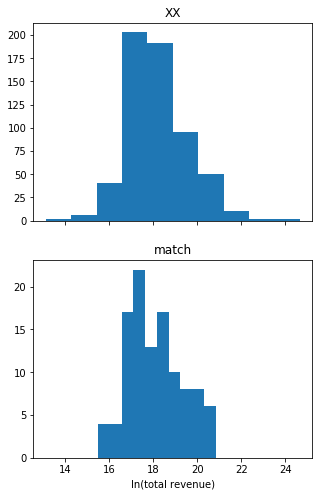

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5,8), sharex=True)

ax[0].hist(np.log(Y_XX.values.ravel()))
ax[0].set_title('XX')

ax[1].hist(np.log(Y_match.values.ravel()))
ax[1].set_title('match')
ax[1].set_xlabel('ln(total revenue)')

plt.show(fig)

In [5]:
X_cols

['channelGrouping.(Other)',
 'channelGrouping.Affiliates',
 'channelGrouping.Direct',
 'channelGrouping.Display',
 'channelGrouping.Organic Search',
 'channelGrouping.Paid Search',
 'channelGrouping.Referral',
 'channelGrouping.Social',
 'device.browser.Android Webview',
 'device.browser.Chrome',
 'device.browser.Firefox',
 'device.browser.Internet Explorer',
 'device.browser.OTHER',
 'device.browser.Safari',
 'device.operatingSystem.(not set)',
 'device.operatingSystem.Android',
 'device.operatingSystem.Chrome OS',
 'device.operatingSystem.Linux',
 'device.operatingSystem.Macintosh',
 'device.operatingSystem.OTHER',
 'device.operatingSystem.Windows',
 'device.operatingSystem.iOS',
 'geoNetwork.subContinent.Eastern Asia',
 'geoNetwork.subContinent.Northern America',
 'geoNetwork.subContinent.Northern Europe',
 'geoNetwork.subContinent.OTHER',
 'geoNetwork.subContinent.Southeast Asia',
 'geoNetwork.subContinent.Southern Asia',
 'geoNetwork.subContinent.Western Europe',
 'trafficSource.s

## Baseline

In [6]:
def get_RMSE(Y, Y_prediction):
    RMSE = np.sqrt(mean_squared_error(np.log(Y+1), np.log(Y_prediction+1)))
    return RMSE

# scorer
scorer = make_scorer(get_RMSE, greater_is_better=False)

Just predict the mean, and see what the RMSE is:

In [7]:
Y_match_baseline = np.ones(len(Y_match)) * np.mean(Y_match.values)
Y_XX_baseline = np.ones(len(Y_XX)) * np.mean(Y_XX.values)

RMSE_match_baseline = get_RMSE(Y_match, Y_match_baseline)
RMSE_XX_baseline = get_RMSE(Y_XX, Y_XX_baseline)

print('match baseline RMSE = {:.3f}'.format(RMSE_match_baseline))
print('XX    baseline RMSE = {:.3f}'.format(RMSE_XX_baseline))

match baseline RMSE = 1.528
XX    baseline RMSE = 2.054


In [8]:
# cross-validation for estimating model performance
outer_cv = KFold(n_splits=5, shuffle=True, random_state=2019)

## Linear Regression

In [9]:
def get_RMSE_LR(Y, Y_prediction):
    Y_prediction_masked = Y_prediction.copy()
    Y_prediction_masked[Y_prediction_masked<0] = 0
    RMSE = np.sqrt(mean_squared_error(np.log(Y+1), np.log(Y_prediction_masked+1)))
    return RMSE

scorer_LR = make_scorer(get_RMSE_LR, greater_is_better=False)

In [10]:
LR = LinearRegression(normalize=False)

RMSE_LR = cross_val_score(LR, X=X_match, y=Y_match.values.ravel(),
                          cv=outer_cv, scoring=scorer_LR)

print('LR RMSE = {:.3f}'.format(np.mean(np.abs(RMSE_LR))))

LR RMSE = 8.432


## RFR - Match Data

Just look at the "match" training slice, which matches the dates exactly of the evaluation set, but one year previous.

Here, we perform nested cross validation, since we have a small sample size.

In [11]:
len(Y_match)

109

In [12]:
# the hyperparameter search grid
n_estimators_HPT_1 = np.array([25,50,75])
max_depth_HPT_1 = np.arange(1, 11, 1)
min_samples_leaf_HPT_1 = np.arange(5, 16, 1)

param_grid = {'n_estimators':n_estimators_HPT_1,
              'max_depth':max_depth_HPT_1,
              'min_samples_leaf':min_samples_leaf_HPT_1}

# the regressor
RFR = RandomForestRegressor(random_state=1111)
    
# kfold for the inner and outer loops
inner_cv = KFold(n_splits=5, shuffle=True, random_state=2222)

# non-nested parameter search and scoring
GSCV = GridSearchCV(estimator=RFR, param_grid=param_grid, cv=inner_cv,
                    scoring=scorer, iid=False)
GSCV.fit(X_match, Y_match.values.ravel())

# get performance for each of the hyperparameters
GSCV_params_1 = pd.DataFrame(GSCV.cv_results_['params'])
GSCV_params_1['mean_test_RMSE'] = np.abs(GSCV.cv_results_['mean_test_score'])
GSCV_params_1['std_test_RMSE'] = GSCV.cv_results_['std_test_score']

# nested CV
nested_score = cross_validate(GSCV.best_estimator_, X=X_match, y=Y_match.values.ravel(),
                              cv=outer_cv, scoring=scorer, return_estimator=True)

print('outer cross-validation results:')
print('-------------------------------')
print("%0.3f (+/-%0.03f) for %r"
      % (abs(nested_score['test_score'].mean()), nested_score['test_score'].std(), GSCV.best_params_))

outer cross-validation results:
-------------------------------
1.390 (+/-0.186) for {'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 75}


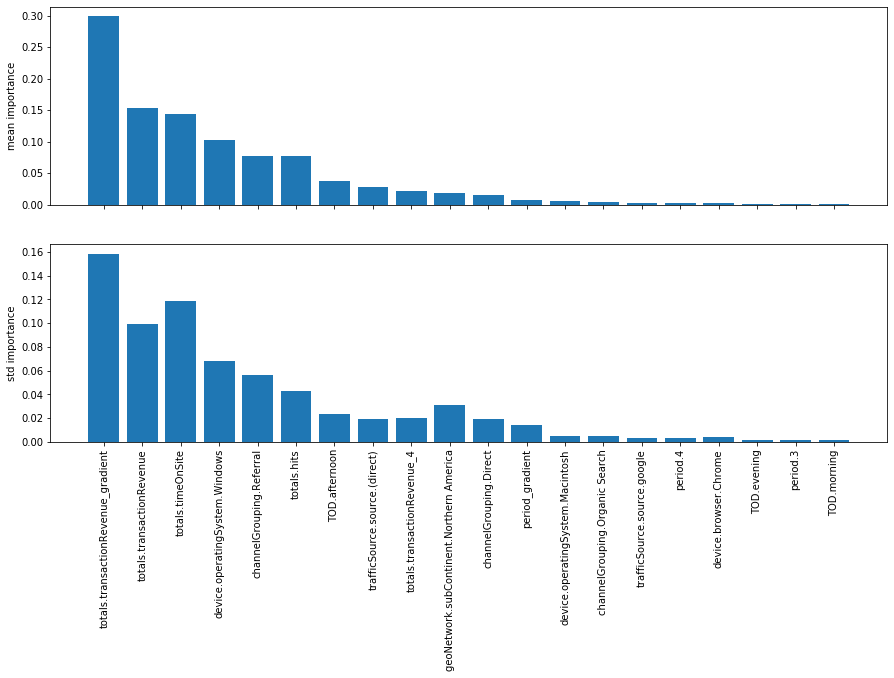

In [13]:
feature_importances = pd.DataFrame({'feature':X_match.columns})

feature_importances_vals = np.zeros((len(feature_importances), len(nested_score['estimator'])))

for i in range(len(nested_score['estimator'])):
    feature_importances_vals[:,i] = nested_score['estimator'][i].feature_importances_
    
feature_importances['importance'] = np.mean(feature_importances_vals, axis=1)
feature_importances['std'] = np.std(feature_importances_vals, axis=1)
feature_importances.sort_values('importance', ascending=False, inplace=True)
feature_importances.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,8), sharex=True)

cut_off = 20

x_inds = np.arange(cut_off)

ax[0].bar(x_inds, feature_importances['importance'][:cut_off])
ax[0].set_ylabel('mean importance')

ax[1].bar(x_inds, feature_importances['std'][:cut_off])
ax[1].set_ylabel('std importance')

ax[1].set_xticks(x_inds)
ax[1].set_xticklabels(feature_importances['feature'][:cut_off], rotation=90)

plt.show(fig)

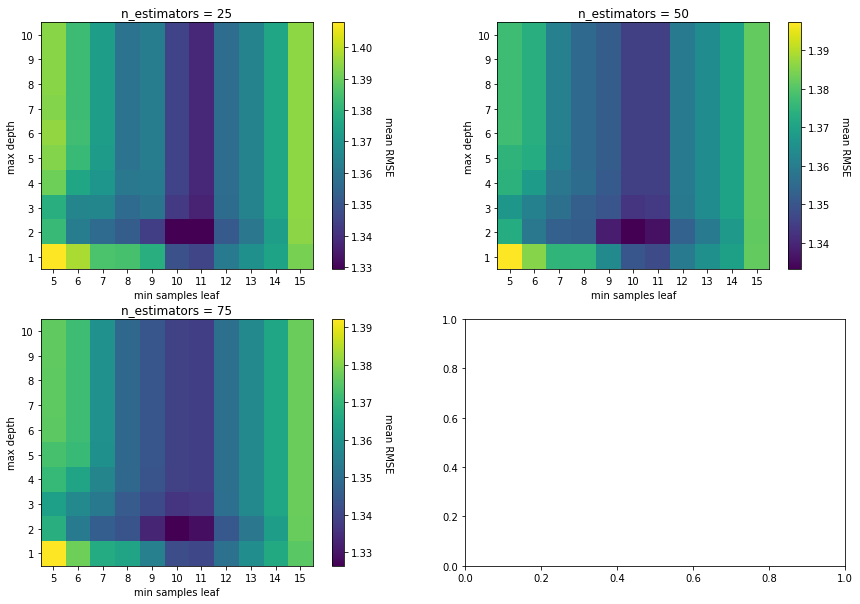

In [14]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

ax = ax.flatten()

for i in range(len(n_estimators_HPT_1)):
    
    params_slice = GSCV_params_1[GSCV_params_1['n_estimators']==n_estimators_HPT_1[i]].copy()
    params_slice = params_slice.pivot(index='max_depth', columns='min_samples_leaf', values='mean_test_RMSE')
    
    im = ax[i].imshow(params_slice.values, origin='lower')
    
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_ylabel('mean RMSE', rotation=-90, labelpad=20)
    
    ax[i].set_title('n_estimators = {}'.format(n_estimators_HPT_1[i]))
    
    ax[i].set_xticks(np.arange(len(min_samples_leaf_HPT_1)))
    ax[i].set_xticklabels(min_samples_leaf_HPT_1)
    ax[i].set_xlabel('min samples leaf')

    ax[i].set_yticks(np.arange(len(max_depth_HPT_1)))
    ax[i].set_yticklabels(max_depth_HPT_1)
    ax[i].set_ylabel('max depth')
    
plt.show(fig)

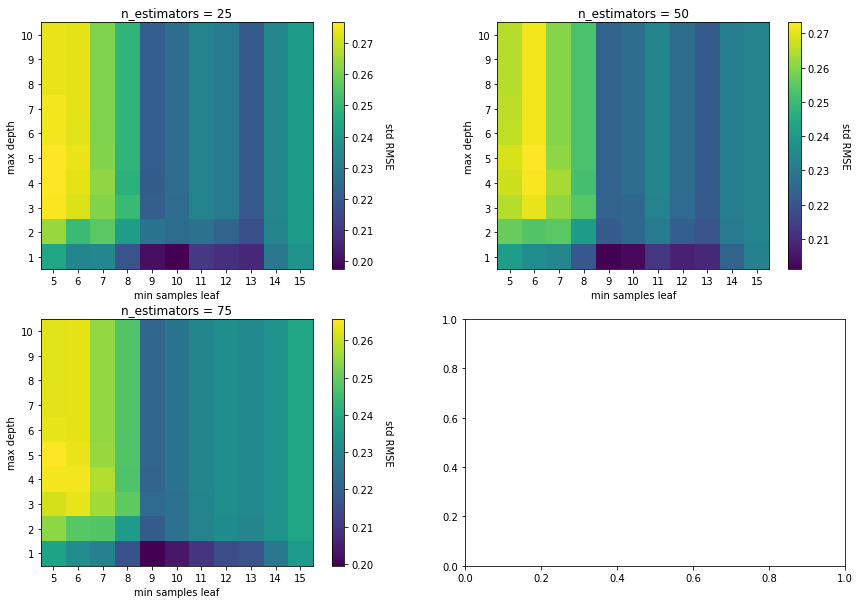

In [15]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

ax = ax.flatten()

for i in range(len(n_estimators_HPT_1)):
    
    params_slice = GSCV_params_1[GSCV_params_1['n_estimators']==n_estimators_HPT_1[i]].copy()
    params_slice = params_slice.pivot(index='max_depth', columns='min_samples_leaf', values='std_test_RMSE')
    
    im = ax[i].imshow(params_slice.values, origin='lower')
    
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_ylabel('std RMSE', rotation=-90, labelpad=20)
    
    ax[i].set_title('n_estimators = {}'.format(n_estimators_HPT_1[i]))
    
    ax[i].set_xticks(np.arange(len(min_samples_leaf_HPT_1)))
    ax[i].set_xticklabels(min_samples_leaf_HPT_1)
    ax[i].set_xlabel('min samples leaf')

    ax[i].set_yticks(np.arange(len(max_depth_HPT_1)))
    ax[i].set_yticklabels(max_depth_HPT_1)
    ax[i].set_ylabel('max depth')
    
plt.show(fig)

## RFR - Simple Match Data

Just look at the "match" training slice, which matches the dates exactly of the evaluation set, but one year previous, and only take a few of the features.

Here, we perform nested cross validation, since we have a small sample size.

In [16]:
X_cols_simple = feature_importances['feature'][:9]

X_match_simple = X_match[X_cols_simple]

In [17]:
# the hyperparameter search grid
n_estimators_HPT_2 = np.array([25,50,75])
max_depth_HPT_2 = np.arange(1, 11, 1)
min_samples_leaf_HPT_2 = np.arange(5, 16, 1)

param_grid = {'n_estimators':n_estimators_HPT_2,
              'max_depth':max_depth_HPT_2,
              'min_samples_leaf':min_samples_leaf_HPT_2}

# the regressor
RFR = RandomForestRegressor(random_state=1111)

# kfold for the inner and outer loops
inner_cv = KFold(n_splits=5, shuffle=True, random_state=2222)

# non-nested parameter search and scoring
GSCV = GridSearchCV(estimator=RFR, param_grid=param_grid, cv=inner_cv,
                    scoring=scorer, iid=False)
GSCV.fit(X_match_simple, Y_match.values.ravel())

# get performance for each of the hyperparameters
GSCV_params_2 = pd.DataFrame(GSCV.cv_results_['params'])
GSCV_params_2['mean_test_RMSE'] = np.abs(GSCV.cv_results_['mean_test_score'])
GSCV_params_2['std_test_RMSE'] = GSCV.cv_results_['std_test_score']

# nested CV
nested_score = cross_validate(GSCV.best_estimator_, X=X_match_simple, y=Y_match.values.ravel(),
                              cv=outer_cv, scoring=scorer, return_estimator=True)

print('outer cross-validation results:')
print('-------------------------------')
print("%0.3f (+/-%0.03f) for %r"
      % (abs(nested_score['test_score'].mean()), nested_score['test_score'].std(), GSCV.best_params_))

outer cross-validation results:
-------------------------------
1.380 (+/-0.158) for {'max_depth': 2, 'min_samples_leaf': 11, 'n_estimators': 75}


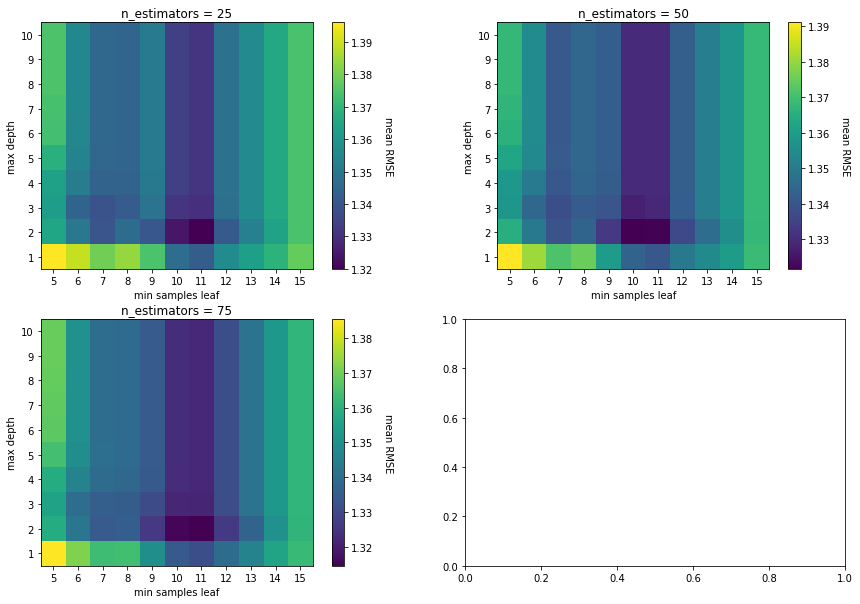

In [18]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

ax = ax.flatten()

for i in range(len(n_estimators_HPT_2)):
    
    params_slice = GSCV_params_2[GSCV_params_2['n_estimators']==n_estimators_HPT_2[i]].copy()
    params_slice = params_slice.pivot(index='max_depth', columns='min_samples_leaf', values='mean_test_RMSE')
    
    im = ax[i].imshow(params_slice.values, origin='lower')
    
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_ylabel('mean RMSE', rotation=-90, labelpad=20)
    
    ax[i].set_title('n_estimators = {}'.format(n_estimators_HPT_2[i]))
    
    ax[i].set_xticks(np.arange(len(min_samples_leaf_HPT_2)))
    ax[i].set_xticklabels(min_samples_leaf_HPT_2)
    ax[i].set_xlabel('min samples leaf')

    ax[i].set_yticks(np.arange(len(max_depth_HPT_2)))
    ax[i].set_yticklabels(max_depth_HPT_2)
    ax[i].set_ylabel('max depth')
    
plt.show(fig)

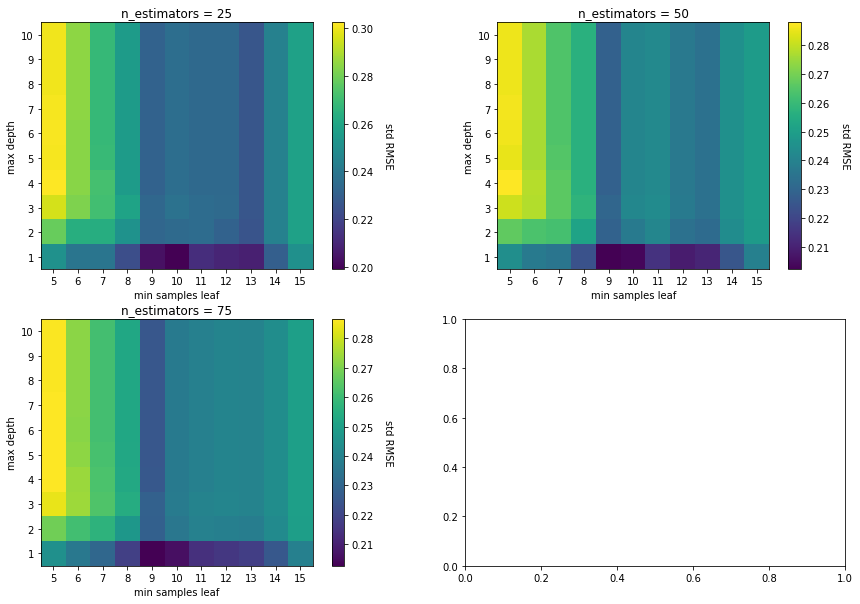

In [19]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

ax = ax.flatten()

for i in range(len(n_estimators_HPT_2)):
    
    params_slice = GSCV_params_2[GSCV_params_2['n_estimators']==n_estimators_HPT_2[i]].copy()
    params_slice = params_slice.pivot(index='max_depth', columns='min_samples_leaf', values='std_test_RMSE')
    
    im = ax[i].imshow(params_slice.values, origin='lower')
    
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_ylabel('std RMSE', rotation=-90, labelpad=20)
    
    ax[i].set_title('n_estimators = {}'.format(n_estimators_HPT_2[i]))
    
    ax[i].set_xticks(np.arange(len(min_samples_leaf_HPT_2)))
    ax[i].set_xticklabels(min_samples_leaf_HPT_2)
    ax[i].set_xlabel('min samples leaf')

    ax[i].set_yticks(np.arange(len(max_depth_HPT_2)))
    ax[i].set_yticklabels(max_depth_HPT_2)
    ax[i].set_ylabel('max depth')
    
plt.show(fig)

## RFR - XX Data

Train on the "XX" slices, which are just 5 even spaces time slices in the training.csv concatenated together. This approach ignores seasonality, but increases the number of data points that we use to train with.

In [20]:
len(Y_XX)

603

In [21]:
# the hyperparameter search grid
n_estimators_HPT_3 = np.array([25,50,75])
max_depth_HPT_3 = np.arange(2, 16, 1)
min_samples_leaf_HPT_3 = np.arange(1, 11, 1)

param_grid = {'n_estimators':n_estimators_HPT_3,
              'max_depth':max_depth_HPT_3,
              'min_samples_leaf':min_samples_leaf_HPT_3}

# the regressor
RFR = RandomForestRegressor(random_state=1111)
    
# kfold for the inner loop only - use the same kfold from before for the outer
inner_cv = KFold(n_splits=5, shuffle=True, random_state=2222)

# non-nested parameter search and scoring
GSCV = GridSearchCV(estimator=RFR, param_grid=param_grid, cv=inner_cv,
                    scoring=scorer, iid=False)
GSCV.fit(X_XX, Y_XX.values.ravel())

# get performance for each of the hyperparameters
GSCV_params_3 = pd.DataFrame(GSCV.cv_results_['params'])
GSCV_params_3['mean_test_RMSE'] = np.abs(GSCV.cv_results_['mean_test_score'])
GSCV_params_3['std_test_RMSE'] = GSCV.cv_results_['std_test_score']

# nested CV
nested_score = cross_validate(GSCV.best_estimator_, X=X_match, y=Y_match.values.ravel(),
                              cv=outer_cv, scoring=scorer, return_estimator=True)

print('outer cross-validation results:')
print('-------------------------------')
print("%0.3f (+/-%0.03f) for %r"
      % (abs(nested_score['test_score'].mean()), nested_score['test_score'].std(), GSCV.best_params_))

outer cross-validation results:
-------------------------------
1.446 (+/-0.230) for {'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 25}


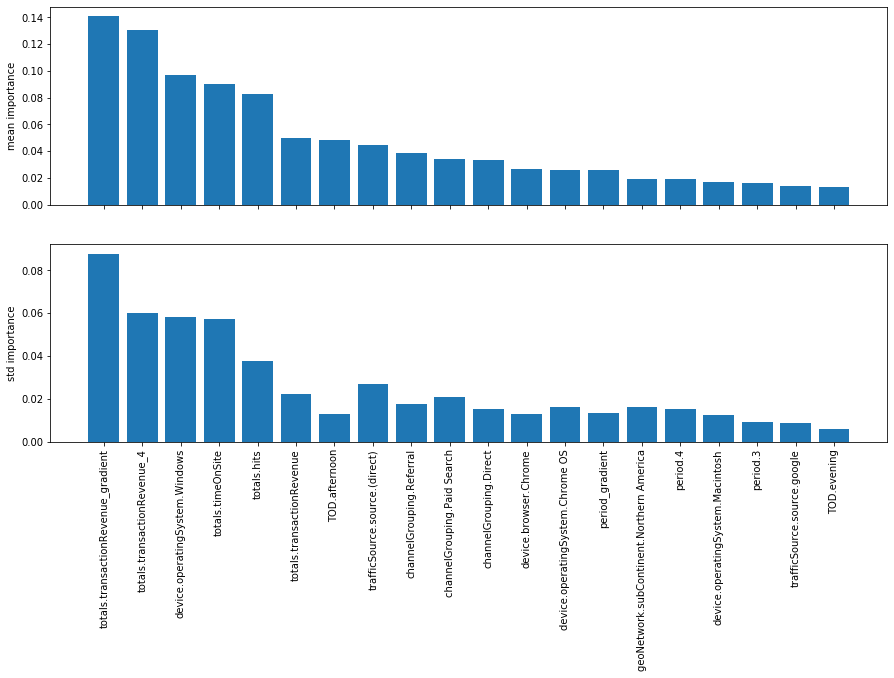

In [22]:
feature_importances = pd.DataFrame({'feature':X_match.columns})

feature_importances_vals = np.zeros((len(feature_importances), len(nested_score['estimator'])))

for i in range(len(nested_score['estimator'])):
    feature_importances_vals[:,i] = nested_score['estimator'][i].feature_importances_
    
feature_importances['importance'] = np.mean(feature_importances_vals, axis=1)
feature_importances['std'] = np.std(feature_importances_vals, axis=1)
feature_importances.sort_values('importance', ascending=False, inplace=True)
feature_importances.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,8), sharex=True)

cut_off = 20

x_inds = np.arange(cut_off)

ax[0].bar(x_inds, feature_importances['importance'][:cut_off])
ax[0].set_ylabel('mean importance')

ax[1].bar(x_inds, feature_importances['std'][:cut_off])
ax[1].set_ylabel('std importance')

ax[1].set_xticks(x_inds)
ax[1].set_xticklabels(feature_importances['feature'][:cut_off], rotation=90)

plt.show(fig)

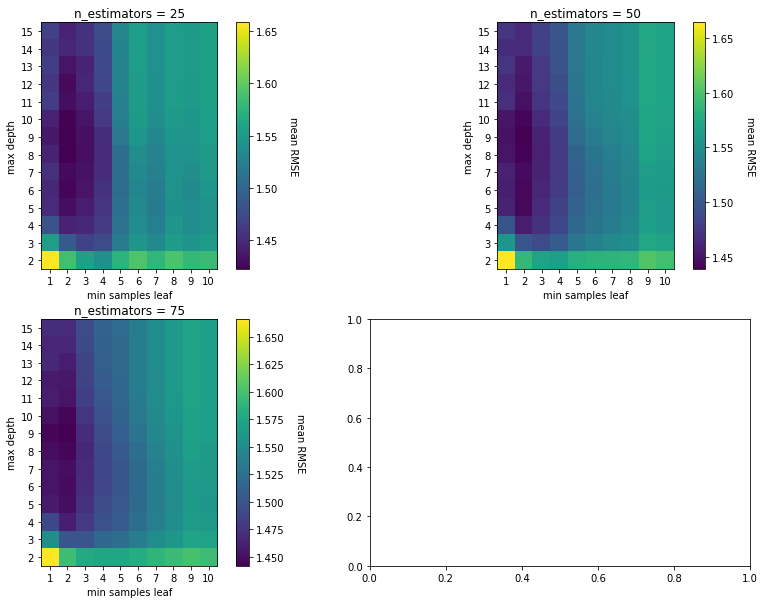

In [23]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

ax = ax.flatten()

for i in range(len(n_estimators_HPT_3)):
    
    params_slice = GSCV_params_3[GSCV_params_3['n_estimators']==n_estimators_HPT_3[i]].copy()
    params_slice = params_slice.pivot(index='max_depth', columns='min_samples_leaf', values='mean_test_RMSE')
    
    im = ax[i].imshow(params_slice.values, origin='lower')
    
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_ylabel('mean RMSE', rotation=-90, labelpad=20)
    
    ax[i].set_title('n_estimators = {}'.format(n_estimators_HPT_3[i]))
    
    ax[i].set_xticks(np.arange(len(min_samples_leaf_HPT_3)))
    ax[i].set_xticklabels(min_samples_leaf_HPT_3)
    ax[i].set_xlabel('min samples leaf')

    ax[i].set_yticks(np.arange(len(max_depth_HPT_3)))
    ax[i].set_yticklabels(max_depth_HPT_3)
    ax[i].set_ylabel('max depth')
    
plt.show(fig)

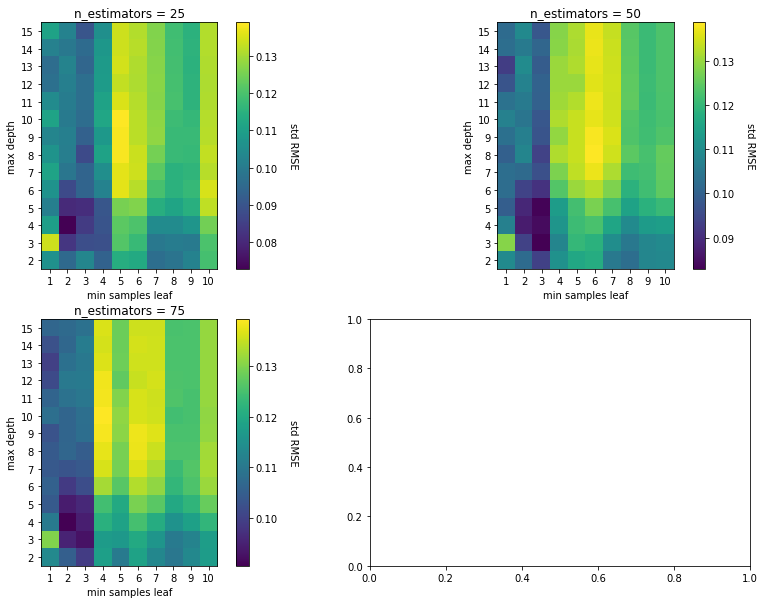

In [24]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

ax = ax.flatten()

for i in range(len(n_estimators_HPT_3)):
    
    params_slice = GSCV_params_3[GSCV_params_3['n_estimators']==n_estimators_HPT_3[i]].copy()
    params_slice = params_slice.pivot(index='max_depth', columns='min_samples_leaf', values='std_test_RMSE')
    
    im = ax[i].imshow(params_slice.values, origin='lower')
    
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_ylabel('std RMSE', rotation=-90, labelpad=20)
    
    ax[i].set_title('n_estimators = {}'.format(n_estimators_HPT_3[i]))
    
    ax[i].set_xticks(np.arange(len(min_samples_leaf_HPT_3)))
    ax[i].set_xticklabels(min_samples_leaf_HPT_3)
    ax[i].set_xlabel('min samples leaf')

    ax[i].set_yticks(np.arange(len(max_depth_HPT_3)))
    ax[i].set_yticklabels(max_depth_HPT_3)
    ax[i].set_ylabel('max depth')
    
plt.show(fig)

## GBR - Match Data

In [25]:
# the hyperparameter search grid
n_estimators_HPT_4 = np.array([25,50,75])
learning_rate_HPT_4 = np.linspace(0.001, 0.2, 10)
min_samples_leaf_HPT_4 = np.arange(2, 22, 2)

param_grid = {'n_estimators':n_estimators_HPT_4,
              'learning_rate':learning_rate_HPT_4,
              'min_samples_leaf':min_samples_leaf_HPT_4}

# the regressor
GBR = GradientBoostingRegressor(random_state=1111)
    
# kfold for the inner and outer loops
inner_cv = KFold(n_splits=5, shuffle=True, random_state=2222)

# non-nested parameter search and scoring
GSCV = GridSearchCV(estimator=GBR, param_grid=param_grid, cv=inner_cv,
                    scoring=scorer_LR, iid=False)
GSCV.fit(X_match, Y_match.values.ravel())

# get performance for each of the hyperparameters
GSCV_params_4 = pd.DataFrame(GSCV.cv_results_['params'])
GSCV_params_4['mean_test_RMSE'] = np.abs(GSCV.cv_results_['mean_test_score'])
GSCV_params_4['std_test_RMSE'] = GSCV.cv_results_['std_test_score']

# nested CV
nested_score = cross_validate(GSCV.best_estimator_, X=X_match, y=Y_match.values.ravel(),
                              cv=outer_cv, scoring=scorer_LR, return_estimator=True)

print('outer cross-validation results:')
print('-------------------------------')
print("%0.3f (+/-%0.03f) for %r"
      % (abs(nested_score['test_score'].mean()), nested_score['test_score'].std(), GSCV.best_params_))

outer cross-validation results:
-------------------------------
1.421 (+/-0.186) for {'learning_rate': 0.045222222222222226, 'min_samples_leaf': 14, 'n_estimators': 50}


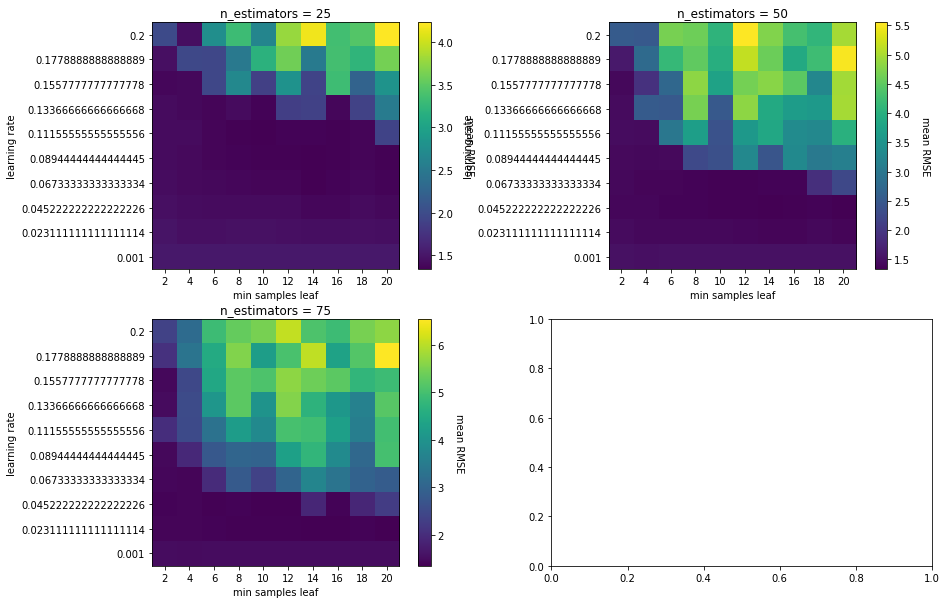

In [26]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

ax = ax.flatten()

for i in range(len(n_estimators_HPT_4)):
    
    params_slice = GSCV_params_4[GSCV_params_4['n_estimators']==n_estimators_HPT_4[i]].copy()
    params_slice = params_slice.pivot(index='learning_rate', columns='min_samples_leaf', values='mean_test_RMSE')
    
    im = ax[i].imshow(params_slice.values, origin='lower')
    
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_ylabel('mean RMSE', rotation=-90, labelpad=20)
    
    ax[i].set_title('n_estimators = {}'.format(n_estimators_HPT_4[i]))
    
    ax[i].set_xticks(np.arange(len(min_samples_leaf_HPT_4)))
    ax[i].set_xticklabels(min_samples_leaf_HPT_4)
    ax[i].set_xlabel('min samples leaf')

    ax[i].set_yticks(np.arange(len(learning_rate_HPT_4)))
    ax[i].set_yticklabels(learning_rate_HPT_4)
    ax[i].set_ylabel('learning rate')
    
plt.show(fig)

## GBR - XX Data

In [27]:
# the hyperparameter search grid
n_estimators_HPT_5 = np.array([25,50,75])
learning_rate_HPT_5 = np.linspace(0.001, 0.2, 10)
min_samples_leaf_HPT_5 = np.arange(2, 22, 2)

param_grid = {'n_estimators':n_estimators_HPT_5,
              'learning_rate':learning_rate_HPT_5,
              'min_samples_leaf':min_samples_leaf_HPT_5}

# the regressor
GBR = GradientBoostingRegressor(random_state=1111)
    
# kfold for the inner and outer loops
inner_cv = KFold(n_splits=5, shuffle=True, random_state=2222)

# non-nested parameter search and scoring
GSCV = GridSearchCV(estimator=GBR, param_grid=param_grid, cv=inner_cv,
                    scoring=scorer_LR, iid=False)
GSCV.fit(X_XX, Y_XX.values.ravel())

# get performance for each of the hyperparameters
GSCV_params_5 = pd.DataFrame(GSCV.cv_results_['params'])
GSCV_params_5['mean_test_RMSE'] = np.abs(GSCV.cv_results_['mean_test_score'])
GSCV_params_5['std_test_RMSE'] = GSCV.cv_results_['std_test_score']

# nested CV
nested_score = cross_validate(GSCV.best_estimator_, X=X_match, y=Y_match.values.ravel(),
                              cv=outer_cv, scoring=scorer_LR, return_estimator=True)

print('outer cross-validation results:')
print('-------------------------------')
print("%0.3f (+/-%0.03f) for %r"
      % (abs(nested_score['test_score'].mean()), nested_score['test_score'].std(), GSCV.best_params_))

outer cross-validation results:
-------------------------------
1.484 (+/-0.234) for {'learning_rate': 0.1557777777777778, 'min_samples_leaf': 2, 'n_estimators': 25}


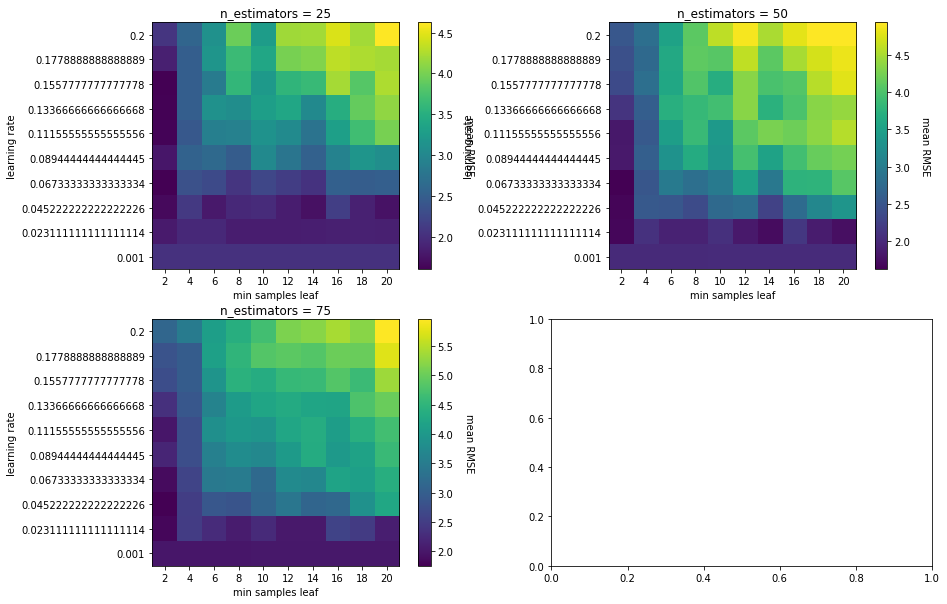

In [28]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

ax = ax.flatten()

for i in range(len(n_estimators_HPT_5)):
    
    params_slice = GSCV_params_5[GSCV_params_5['n_estimators']==n_estimators_HPT_5[i]].copy()
    params_slice = params_slice.pivot(index='learning_rate', columns='min_samples_leaf', values='mean_test_RMSE')
    
    im = ax[i].imshow(params_slice.values, origin='lower')
    
    cbar = fig.colorbar(im, ax=ax[i])
    cbar.ax.set_ylabel('mean RMSE', rotation=-90, labelpad=20)
    
    ax[i].set_title('n_estimators = {}'.format(n_estimators_HPT_5[i]))
    
    ax[i].set_xticks(np.arange(len(min_samples_leaf_HPT_5)))
    ax[i].set_xticklabels(min_samples_leaf_HPT_5)
    ax[i].set_xlabel('min samples leaf')

    ax[i].set_yticks(np.arange(len(learning_rate_HPT_5)))
    ax[i].set_yticklabels(learning_rate_HPT_5)
    ax[i].set_ylabel('learning rate')
    
plt.show(fig)

## MLP - Match Data

In [36]:
# the hyperparameter search grid
hidden_layer_sizes_HPT_6 = np.arange(100,600,100)
alpha_HPT_6 = np.linspace(0.00001, 0.001, 10)

param_grid = {'hidden_layer_sizes':hidden_layer_sizes_HPT_6,
              'alpha':alpha_HPT_6}

# the regressor
MLP = MLPRegressor(solver='lbfgs',random_state=1111)
    
# kfold for the inner and outer loops
inner_cv = KFold(n_splits=5, shuffle=True, random_state=2222)

# non-nested parameter search and scoring
GSCV = GridSearchCV(estimator=MLP, param_grid=param_grid, cv=inner_cv,
                    scoring=scorer_LR, iid=False)
GSCV.fit(X_match, Y_match.values.ravel())

# get performance for each of the hyperparameters
GSCV_params_6 = pd.DataFrame(GSCV.cv_results_['params'])
GSCV_params_6['mean_test_RMSE'] = np.abs(GSCV.cv_results_['mean_test_score'])
GSCV_params_6['std_test_RMSE'] = GSCV.cv_results_['std_test_score']

# nested CV
nested_score = cross_validate(GSCV.best_estimator_, X=X_match, y=Y_match.values.ravel(),
                              cv=outer_cv, scoring=scorer_LR, return_estimator=True)

print('outer cross-validation results:')
print('-------------------------------')
print("%0.3f (+/-%0.03f) for %r"
      % (abs(nested_score['test_score'].mean()), nested_score['test_score'].std(), GSCV.best_params_))

outer cross-validation results:
-------------------------------
7.027 (+/-1.657) for {'alpha': 0.00045000000000000004, 'hidden_layer_sizes': 300}


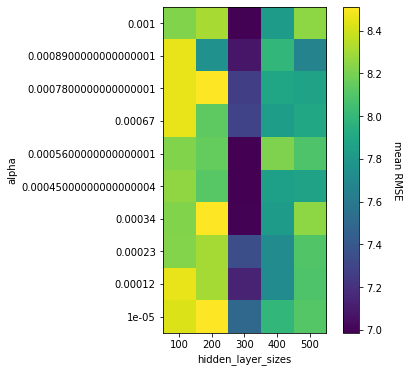

In [37]:
fig, ax = plt.subplots(figsize=(6,6))

params_slice = GSCV_params_6.pivot(index='alpha', columns='hidden_layer_sizes', values='mean_test_RMSE')

im = ax.imshow(params_slice.values, origin='lower')

cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean RMSE', rotation=-90, labelpad=20)

ax.set_xticks(np.arange(len(hidden_layer_sizes_HPT_6)))
ax.set_xticklabels(hidden_layer_sizes_HPT_6)
ax.set_xlabel('hidden_layer_sizes')

ax.set_yticks(np.arange(len(alpha_HPT_6)))
ax.set_yticklabels(alpha_HPT_6)
ax.set_ylabel('alpha')
    
plt.show(fig)

## MLP - XX Data

In [38]:
# the hyperparameter search grid
hidden_layer_sizes_HPT_7 = np.arange(100,600,100)
alpha_HPT_7 = np.linspace(0.00001, 0.001, 10)

param_grid = {'hidden_layer_sizes':hidden_layer_sizes_HPT_7,
              'alpha':alpha_HPT_7}

# the regressor
MLP = MLPRegressor(solver='lbfgs',random_state=1111)
    
# kfold for the inner and outer loops
inner_cv = KFold(n_splits=5, shuffle=True, random_state=2222)

# non-nested parameter search and scoring
GSCV = GridSearchCV(estimator=MLP, param_grid=param_grid, cv=inner_cv,
                    scoring=scorer_LR, iid=False)
GSCV.fit(X_XX, Y_XX.values.ravel())

# get performance for each of the hyperparameters
GSCV_params_7 = pd.DataFrame(GSCV.cv_results_['params'])
GSCV_params_7['mean_test_RMSE'] = np.abs(GSCV.cv_results_['mean_test_score'])
GSCV_params_7['std_test_RMSE'] = GSCV.cv_results_['std_test_score']

# nested CV
nested_score = cross_validate(GSCV.best_estimator_, X=X_match, y=Y_match.values.ravel(),
                              cv=outer_cv, scoring=scorer_LR, return_estimator=True)

print('outer cross-validation results:')
print('-------------------------------')
print("%0.3f (+/-%0.03f) for %r"
      % (abs(nested_score['test_score'].mean()), nested_score['test_score'].std(), GSCV.best_params_))

outer cross-validation results:
-------------------------------
7.171 (+/-1.228) for {'alpha': 0.00012, 'hidden_layer_sizes': 300}


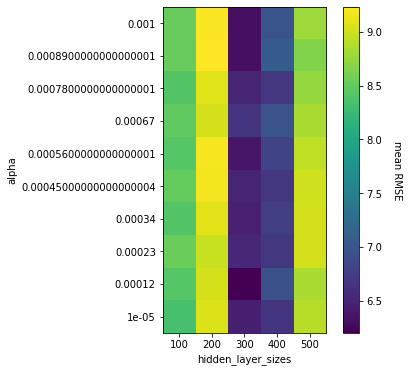

In [39]:
fig, ax = plt.subplots(figsize=(6,6))

params_slice = GSCV_params_7.pivot(index='alpha', columns='hidden_layer_sizes', values='mean_test_RMSE')

im = ax.imshow(params_slice.values, origin='lower')

cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean RMSE', rotation=-90, labelpad=20)

ax.set_xticks(np.arange(len(hidden_layer_sizes_HPT_7)))
ax.set_xticklabels(hidden_layer_sizes_HPT_7)
ax.set_xlabel('hidden_layer_sizes')

ax.set_yticks(np.arange(len(alpha_HPT_7)))
ax.set_yticklabels(alpha_HPT_7)
ax.set_ylabel('alpha')
    
plt.show(fig)

## Summary

| model | mean RMSE | std RMSE |
|-------|-----------|----------|
| match baseline | 1.528 | n/a |
| XX baseline | 2.054 | n/a |
| match LR - CV on match | 8.432 | ... |
| match RFR - CV on match | 1.390 | 0.186 |
| simple match RFR - CV on match | 1.380 | 0.158 |
| XX RFR - CV on match | 1.446 | 0.230 |
| match GBR - CV on match | 1.421 | 0.186 |
| XX GBR - CV on match | 1.493 | 0.246 |
| match MLP - CV on match | 7.027 | 1.657 |
| XX MLP - CV on match | 7.171 | 1.228 |